<a href="https://colab.research.google.com/github/ckkhandare/DS_firstProject/blob/main/DSProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries and loading Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV

In [11]:
df=pd.read_csv('train.csv',na_values='unknown')

# Exploratory Data Analysis

In [12]:
df

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,26110,56,admin.,married,NaN,no,1933,no,no,telephone,19,nov,44,2,-1,0,NaN,no
1,40576,31,NaN,married,secondary,no,3,no,no,cellular,20,jul,91,2,-1,0,NaN,no
2,15320,27,services,married,secondary,no,891,yes,no,cellular,18,jul,240,1,-1,0,NaN,no
3,43962,57,management,divorced,tertiary,no,3287,no,no,cellular,22,jun,867,1,84,3,success,yes
4,29842,31,technician,married,secondary,no,119,yes,no,cellular,4,feb,380,1,-1,0,NaN,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,36483,29,management,single,tertiary,no,0,yes,no,cellular,12,may,116,2,-1,0,NaN,no
31643,40178,53,management,divorced,tertiary,no,380,no,yes,cellular,5,jun,438,2,-1,0,NaN,yes
31644,19710,32,management,single,tertiary,no,312,no,no,cellular,7,aug,37,3,-1,0,NaN,no
31645,38556,57,technician,married,secondary,no,225,yes,no,telephone,15,may,22,7,337,12,failure,no


In [4]:
df.shape

(31647, 18)

In [14]:
df.isnull().sum()*100/31647

ID             0.000000
age            0.000000
job            0.650931
marital        0.000000
education      4.152052
default        0.000000
balance        0.000000
housing        0.000000
loan           0.000000
contact       28.998009
day            0.000000
month          0.000000
duration       0.000000
campaign       0.000000
pdays          0.000000
previous       0.000000
poutcome      81.931937
subscribed     0.000000
dtype: float64

In [6]:
df.select_dtypes(include='O').columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'subscribed'],
      dtype='object')

In [7]:
df.select_dtypes(exclude='O').columns

Index(['ID', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays',
       'previous'],
      dtype='object')

In [15]:
df.education.unique()

array([nan, 'secondary', 'tertiary', 'primary'], dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d2b6b0b90>,
      dtype=object)

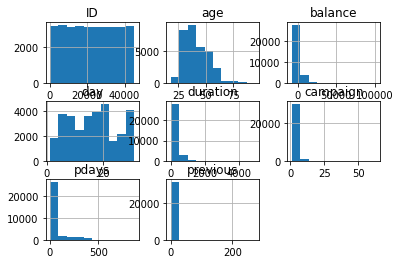

In [16]:
df.hist()

#### Observation

poutcome has more than 80% data missing so it can be droped

education is the only ordinal feature rest all as Nominal ['job','marital','default', 'housing','loan', 'contact','month', 'poutcome','subscribed']

job , education and contact have missing values that need to be imputed